# Test EV control

In [ ]:
from collections import OrderedDict
import pandas as pd
x = OrderedDict(a=1)
x['b']=2
x['a'] = 1
x

In [ ]:
from collections import OrderedDict
import pandas as pd
x = OrderedDict(a=1)
y = {"b":1}
x = {**x, **y}
x
x.update(a=5, b=6)
x

In [ ]:
pd.Series(data=dict(ts=1, Pt=2))

In [ ]:
import pandas as pd
tsd = pd.DataFrame(columns=['ts', 'Pt'])
data = pd.DataFrame(data=dict(ts=1, Pt=2), index=[1])
tsd = pd.concat([tsd, data], ignore_index=True)
tsd = pd.concat([tsd, data], ignore_index=True)
tsd

In [ ]:
sse.tsd

In [ ]:
sse.data

In [ ]:
sse.data

In [ ]:
from ev_ssm import ev_ssm

sse = ev_ssm(ts=18, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA",
             n_pref=1, is_report=True,
             tt_mean=0.5, tt_var=0.2, tt_lb=0, tt_ub=1,
             ict_off=False, ecc_off=False)

sse.data

In [1]:
from ev_ssm import ev_ssm

sse = ev_ssm(ts=18, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA",
             n_pref=1, is_report=True,
             tt_mean=0.5, tt_var=0.2, tt_lb=0, tt_ub=1,
             ict_off=False, ecc_off=False)

sse.load_A("Aest.csv")

sse.run(tf=18 + 5/3600, Pi=0,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=False)

/home/jwang175/andes/jwang/notes/ev_ssm.py:491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ev['na'].iloc[na_rid] = self.ev['nam'].iloc[na_rid]
/home/jwang175/andes/jwang/notes/ev_ssm.py:492: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ev['lc'].iloc[na_rid] = 1
EVA: ts=18[H], 10000 EVs, Total Q=87.7 MWh
Online 2925, Q=73.03 MWh, SoC=0.7717
Power(MW): Pt=-7.9463, Pc=-7.9463, Pd=-0.0
Ctrl: 0=1584; 1=1341; 
EVA: Load A from Aest.csv.
EVA MCS: 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


In [ ]:
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
fig_ev, ax_ev = sse.plot(tu='h', style='default')
# plt.legend(ax_ev, ['1', '2', '3'])
fig_ev.legend()

In [ ]:
ax_ev.get_label()

In [5]:
sse.plot(loc='upper left')

AttributeError: 'Figure' object has no property 'loc'

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [H]', ylabel='Power (MW)'>)

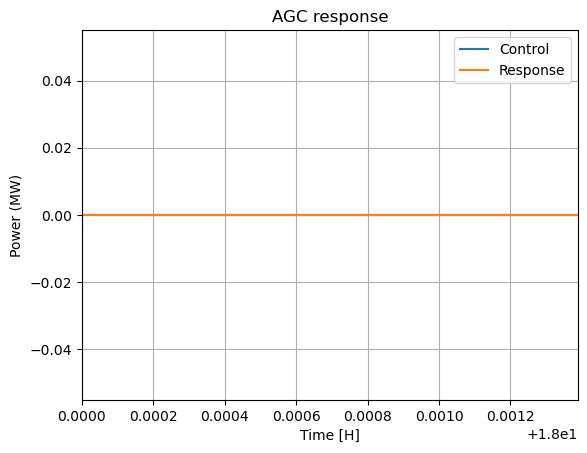

In [2]:
sse.plot_agc(tu='h', style='default')

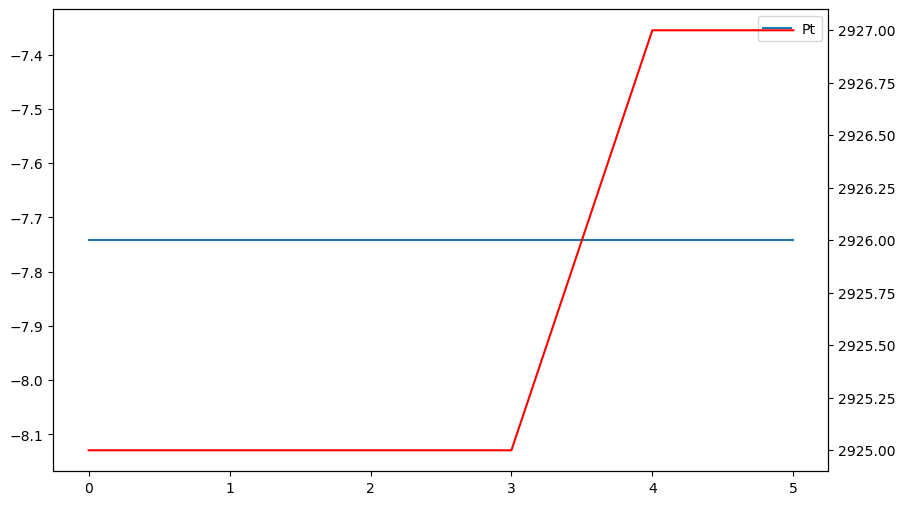

In [3]:
import matplotlib.pyplot as plt
fig_agc, ax_agc = plt.subplots()
sse.tsd.plot(y='Pt', ax=ax_agc, figsize=(10, 6))

ax2 = ax_agc.twinx()
ax2.plot(sse.tsd.index, sse.tsd['ne'], 'r-')

In [ ]:
sse.plot()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ev_ssm import ev_ssm
from tqdm import tqdm
import scipy.stats as stats

In [ ]:
%run -i 'cosim_import.py'

caseH = 18
ict_off = False
ecc_off = False

%run -i 'cosim_setup_andes.py'

%run -i 'cosim_loadsyn.py'

%run -i 'cosim_setup_dispatch.py'

%run -i 'cosim_linktable.py'

# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 3600

rru, rrd, rsfr = 1.0, 1.0, 0.04

# Define functions and constants used in loop
%run -i 'cosim_const.py'

Revise the EV control logic as: C->I, I->D, SOC high to low

In [ ]:
# --- Response ---

sse = ev_ssm(ts=18, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA",
             n_pref=1, is_report=True,
             tt_mean=0.5, tt_var=0.2, tt_lb=0, tt_ub=1,
             ict_off=False, ecc_off=False)
sse.load_A("Aest.csv")

evd0 = sse.ev.copy()

# quiet some EVs by force
np.random.seed(sse.seed)
ict_rid = np.random.randint(low=0,
                            high=sse.ev.shape[0],
                            size=3000)

sse.ev.na.iloc[ict_rid] = sse.ev.nam.iloc[ict_rid]
sse.ev.lc.iloc[ict_rid] = 1
sse.g_u()

# initial EV data
evd0 = sse.ev.copy()

sse.g_frc()

In [ ]:
sse.run(tf=18 + 5/3600, Pi=0,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=False)

sse.run(tf=18 + 50/3600, Pi=10,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=False)

sse.run(tf=18 + 100/3600, Pi=0,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=False)

In [ ]:
sse.nec

In [ ]:
sse.ne

In [ ]:
sse

In [ ]:
u, v, us, vs, usp, vsp = sse.r_agc(10)

In [ ]:
sse.n_pref

In [ ]:
usp.shape

In [ ]:
type(usp)

In [ ]:
sse.plot_agc(tu='s')

In [ ]:
sse.plot_agc(tu='s')

In [ ]:
sse.Prc

In [ ]:
sse.ev[['u', 'c0', 'c', 'lc', 'Pc', 'agc', 'mod']][sse.ev['u'] == 1]

In [ ]:
sse.run(tf=18 + 10/3600, Pi=0,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=False)

sse.run(tf=18 + 60/3600, Pi=10,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=False)
evd = sse.ev.copy()

In [ ]:
evd0[evd0['lc']==1][['u', 'c', 'c0', 'lc', 'na', 'nam']].head()
evd[evd['lc']==1][['u', 'c', 'c0', 'lc', 'na', 'nam']].head()

# row index of evd0 where lc == 1
lcrid = evd0[evd0['lc'] == 1].index

# compared dataframe
evdc = pd.DataFrame()
evdc['lc0'] = evd0['lc']
evdc['lc1'] = evd['lc']
evdc['c0'] = evd0['c']
evdc['c1'] = evd['c']
evdc['soc0'] = evd0['soc']
evdc['soc1'] = evd['soc']
evdc[evdc['lc0']==1][evdc['c0'] != evdc['c1']]

In [ ]:
# plt.plot(sse.Perl)

In [ ]:
sse.xtab.sum().sum()

In [ ]:
sse.nec

In [ ]:
sse.rtab.sum().sum()

In [ ]:
sse.x0.sum()

In [ ]:
sse.plot(tu='s')

In [ ]:
sse.ev['agc'].sum()

In [ ]:
sse.Prc

In [ ]:
sse.plot_agc(tu='s')

In [ ]:
# --- Response ---

# sse = ev_ssm(ts=10.4, N=10000, step=1, tp=40,
#              lr=0.1, lp=40, seed=2022, name="EVA")
# sse.load_A("Aest.csv")

t_list = [60 + 60 * i for i in list(range(7))]
p_list = [2, 0.05, 0.0, 1.0, -0.05, 1, 0]

x0 = sse.x0.copy()
print(sse.Prc)
for t, p in zip(t_list, p_list):
        sse.run(tf=18 + t/3600, Pi=p,
                is_updateA=False, is_rstate=True,
                is_test=False, disable=True)
print(sse.Prc)
x1 = sse.x0.copy()

In [ ]:
plt.plot(sse.tss, sse.Perl)

In [ ]:
sse.plot_agc()

In [ ]:
sse = ev_ssm(ts=10.4, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA",
             is_report=False)

# historical data
ev_num = pd.read_csv("ev_num.csv")

# calculate the sf
k1 = ev_num['ne'][(ev_num['time'] >= sse.ts) & (ev_num['time'] <= sse.ts+1/12)].mean()
k0 = ev_num['ne'][ev_num['time'] >= sse.ts].iloc[0]
k = k1 / k0

# estiamte FRC
sse.g_frc(nea=sse.ne*k)

In [ ]:
## Run to get the EV numbers within a day

# import joblib
# from joblib import Parallel, delayed

# Nt = 10000
# def rne(time):
#     sse1 = ev_ssm(ts=time, N=Nt, step=1, tp=40,
#                   lr=0.1, lp=60, seed=2022, name="EVA",
#                   is_report=False)
#     return sse1.ne

# # interval by minutes, 24H
# rnel = Parallel(n_jobs=joblib.cpu_count())(delayed(rne)(i) for i in np.arange(1/60, 24, 1/60))

# ev_num = pd.DataFrame()
# ev_num['time'] = np.arange(1/60, 24, 1/60)
# ev_num['ne'] = rnel
# ev_num.to_csv("ev_num.csv", index=False)